<a href="https://colab.research.google.com/github/Andyzhang67432/Andyzhang67432.github.io/blob/main/customer_complaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi

Sat Nov 23 18:53:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              30W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [18]:
df = pd.read_csv('complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [19]:
# Renaming columns
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [20]:
# Analysing dataframe attributes
print('* Size of dataframe: {}\n'.format(df.shape))
print('* Datatype of columns are:\n {}\n'.format(df.dtypes))
print('* Count of different product categories:\n {}\n'.format(df['product'].value_counts()))
print('* Number of NaNs among tweets are: {}\n'.format(df['tweet'].isnull().sum()))

* Size of dataframe: (162421, 2)

* Datatype of columns are:
 product    object
tweet      object
dtype: object

* Count of different product categories:
 product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64

* Number of NaNs among tweets are: 10



In [21]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


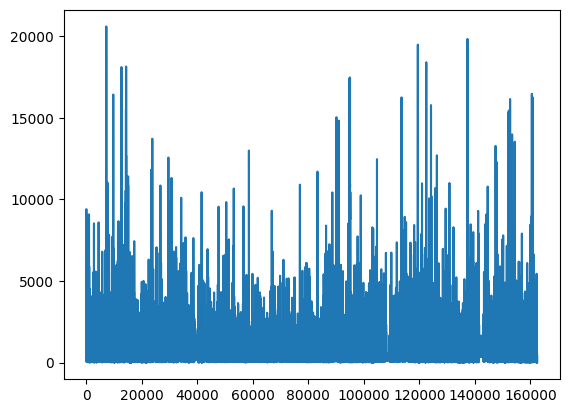

In [22]:
# Plotting word lenghts of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [23]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

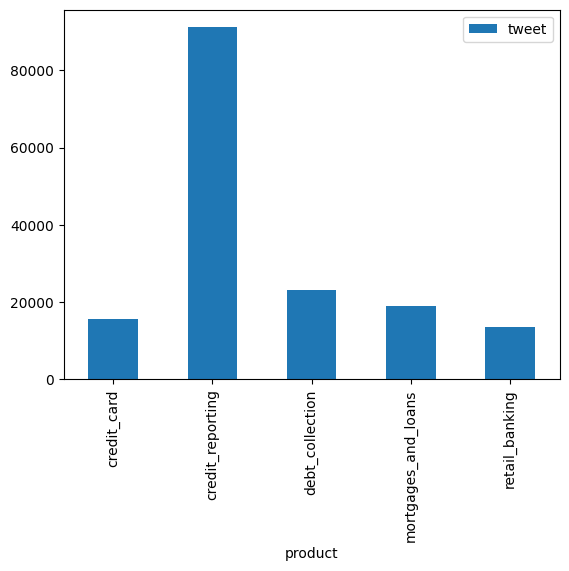

In [24]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

In [25]:
# Importing train test splilt library
from sklearn.model_selection import train_test_split

# Train-Test Splitting
train_data, test_data = train_test_split(df, test_size = 0.20)

In [26]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

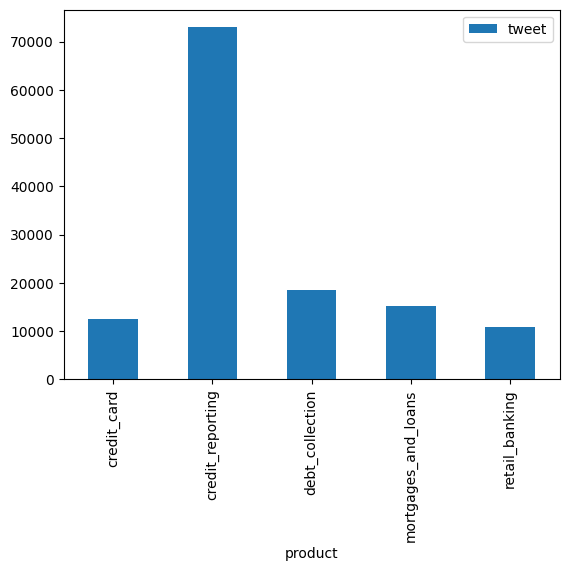

In [27]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

In [28]:
# Train set value counts
train_data.groupby('product').count()

,tweet
product,
credit_card,12429
credit_reporting,72946
debt_collection,18528
mortgages_and_loans,15197
retail_banking,10828


In [29]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False)
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)

# Indices to be added
to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [30]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate

,product,tweet
83301,retail_banking,talked sending twice total via scammer purchas...
124395,credit_card,since ive set payment bank america pay twice m...
84516,retail_banking,unaware cash app account hacked used send doll...
54186,debt_collection,discovered inaccurate information credit repor...
151175,retail_banking,paypal negative transfer p paypal negative tra...
...,...,...
45017,mortgages_and_loans,hyundai account completed lease never received...
144365,credit_card,may concern name man whose life greatly affect...
16219,debt_collection,disputed company company received dispute show...
56684,credit_card,indicated bank america fraud card internet ser...


In [31]:
# Concatenating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

,count
product,
credit_reporting,72946
debt_collection,25528
mortgages_and_loans,22197
credit_card,19429
retail_banking,17828


In [32]:
# Importing NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

# Declaring function for text preprocessing

def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))

  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1

In [33]:
# Preprocessing training and test data
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# Verifying text preprocessing
train_data['tweet'].head()
# Declaring train labels
train_labels = train_data['product']
test_labels = test_data['product']


In [35]:
# Converting labels to numerical features
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19429, 72946, 25528, 22197, 17828]))
(array([0, 1, 2, 3, 4]), array([ 3137, 18226,  4620,  3793,  2707]))


In [36]:
# Changing labels to categorical features
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Defining training parameters
max_sequence_length = 170
max_words = 2500

# Tokenizing tweets/sentences wrt num_words
tokenizer = Tokenizer(num_words = max_words)  # Selects most frequent words
tokenizer.fit_on_texts(train_data.tweet)      # Develops internal vocab based on training text
train_sequences = tokenizer.texts_to_sequences(train_data.tweet)  # converts text to sequence

test_sequences = tokenizer.texts_to_sequences(test_data.tweet)

In [38]:
# Fixing the sequence length
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((157928, 170), (32483, 170))

In [39]:
# Model Parameters
embedding_dim = 32

In [40]:
# Importing Libraries

import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding

In [41]:
embedding_dim = 32

# Model Training
model = Sequential()

# Specify input shape in the Embedding layer
model.add(Embedding(max_words, embedding_dim, input_shape=(max_sequence_length,)))  # Specify input shape

# Bidirectional LSTM
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))

model.add(GlobalMaxPool1D())

model.add(Dense(5, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 170, 32)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 170, 32)             │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,437 (337.64 KB)

 Trainable params: 86,437 (337.64 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])

In [43]:
# declaring weights of product categories
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}

# training and validating model
history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels)) # best 89(now) or 48 or 60 epochs # default epochs = 23 # batch_size changed to 1 (takes 2.30hrs) from 16

Epoch 1/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.6268 - loss: 1.2458 - val_accuracy: 0.8524 - val_loss: 0.1560
Epoch 2/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.8457 - loss: 0.6079 - val_accuracy: 0.8578 - val_loss: 0.1491
Epoch 3/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 77s 16ms/step - accuracy: 0.8582 - loss: 0.5624 - val_accuracy: 0.8681 - val_loss: 0.1407
Epoch 4/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8632 - loss: 0.5422 - val_accuracy: 0.8704 - val_loss: 0.1387
Epoch 5/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8674 - loss: 0.5247 - val_accuracy: 0.8674 - val_loss: 0.1420
Epoch 6/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8679 - loss: 0.5236 - val_accuracy: 0.8673 - val_loss: 0.1408
Epoch 7/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8724 - loss: 0.5109 - val_accuracy: 0.8714 - val_loss: 0.1365
Epoch 8/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8722 -

In [44]:
# Prediction on Test Data
predicted_bi_lstm = model.predict(test_data)
predicted_bi_lstm

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


array([[1.9555655e-04, 3.0805910e-04, 4.4856887e-04, 3.4632350e-04,
        9.9870145e-01],
       [4.9286944e-05, 1.6914966e-04, 2.2657447e-04, 9.9952340e-01,
        3.1593285e-05],
       [3.1376470e-04, 1.2583187e-03, 2.3198393e-04, 9.9818075e-01,
        1.5102976e-05],
       ...,
       [1.1525337e-05, 8.6216263e-05, 7.4791245e-04, 9.9915195e-01,
        2.3615114e-06],
       [3.0914913e-07, 9.9996829e-01, 2.8275665e-05, 2.6944738e-06,
        3.4306541e-07],
       [1.6999127e-03, 1.0253765e-02, 9.8644871e-01, 6.4734014e-04,
        9.5024472e-04]], dtype=float32)

In [45]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.80613621 0.92573574 0.7976326  0.86723947 0.84072022]
recall: [0.76219318 0.91989466 0.75844156 0.82494068 0.89693388]
fscore: [0.78354907 0.92280596 0.77754355 0.84556141 0.86791778]
support: [ 3137 18226  4620  3793  2707]
################################
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      3137
           1       0.93      0.92      0.92     18226
           2       0.80      0.76      0.78      4620
           3       0.87      0.82      0.85      3793
           4       0.84      0.90      0.87      2707

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.85      0.83      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


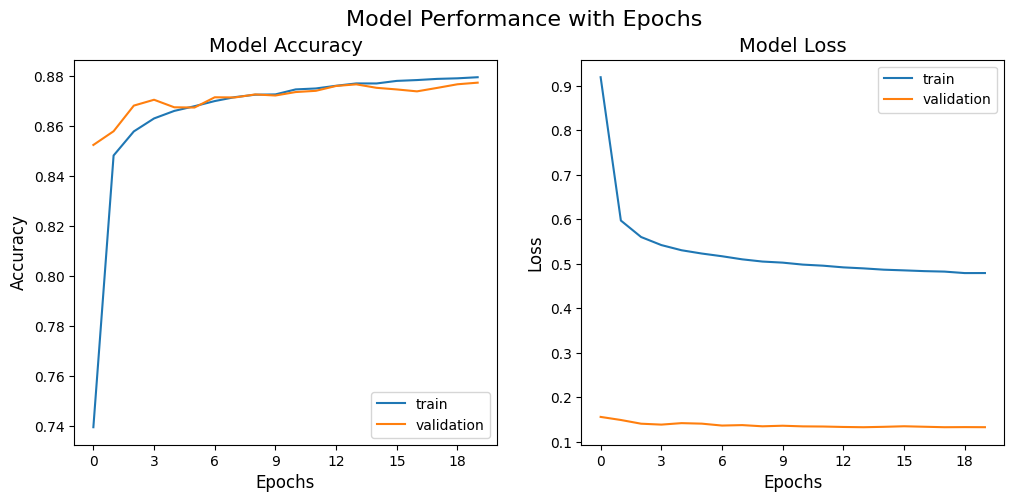

In [46]:
def accuracy_plot(history):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integers
    # Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integers

accuracy_plot(history)

In [47]:
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}

# training and validating model
bi_lstm_50 = model.fit(train_data, train_labels, batch_size=48, epochs= 50, class_weight = class_weight, validation_data=(test_data, test_labels))

Epoch 1/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.8813 - loss: 0.4686 - val_accuracy: 0.8747 - val_loss: 0.1333
Epoch 2/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8800 - loss: 0.4747 - val_accuracy: 0.8756 - val_loss: 0.1333
Epoch 3/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8814 - loss: 0.4705 - val_accuracy: 0.8758 - val_loss: 0.1331
Epoch 4/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8825 - loss: 0.4712 - val_accuracy: 0.8734 - val_loss: 0.1348
Epoch 5/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.8825 - loss: 0.4665 - val_accuracy: 0.8760 - val_loss: 0.1319
Epoch 6/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.8832 - loss: 0.4699 - val_accuracy: 0.8747 - val_loss: 0.1335
Epoch 7/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.8831 - loss: 0.4660 - val_accuracy: 0.8762 - val_loss: 0.1321
Epoch 8/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.8819 -

In [48]:
# Prediction on Test Data
predicted_bi_lstm_50 = model.predict(test_data)
predicted_bi_lstm_50

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


array([[7.0966023e-05, 3.1831121e-05, 2.5566831e-05, 1.6614448e-04,
        9.9970549e-01],
       [2.4534563e-06, 7.6685619e-06, 1.9729736e-05, 9.9996173e-01,
        8.3264003e-06],
       [4.5198278e-04, 1.2271593e-02, 4.6603815e-04, 9.8664099e-01,
        1.6946525e-04],
       ...,
       [2.2066536e-07, 3.9656461e-06, 1.0914054e-05, 9.9998438e-01,
        5.3505852e-07],
       [1.3921899e-05, 9.9994981e-01, 2.9336041e-05, 6.5006034e-06,
        3.9641833e-07],
       [3.7776097e-03, 3.2264371e-03, 9.6731710e-01, 2.4845855e-02,
        8.3302811e-04]], dtype=float32)

In [49]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.80613621 0.92573574 0.7976326  0.86723947 0.84072022]
recall: [0.76219318 0.91989466 0.75844156 0.82494068 0.89693388]
fscore: [0.78354907 0.92280596 0.77754355 0.84556141 0.86791778]
support: [ 3137 18226  4620  3793  2707]
################################
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      3137
           1       0.93      0.92      0.92     18226
           2       0.80      0.76      0.78      4620
           3       0.87      0.82      0.85      3793
           4       0.84      0.90      0.87      2707

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.85      0.83      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


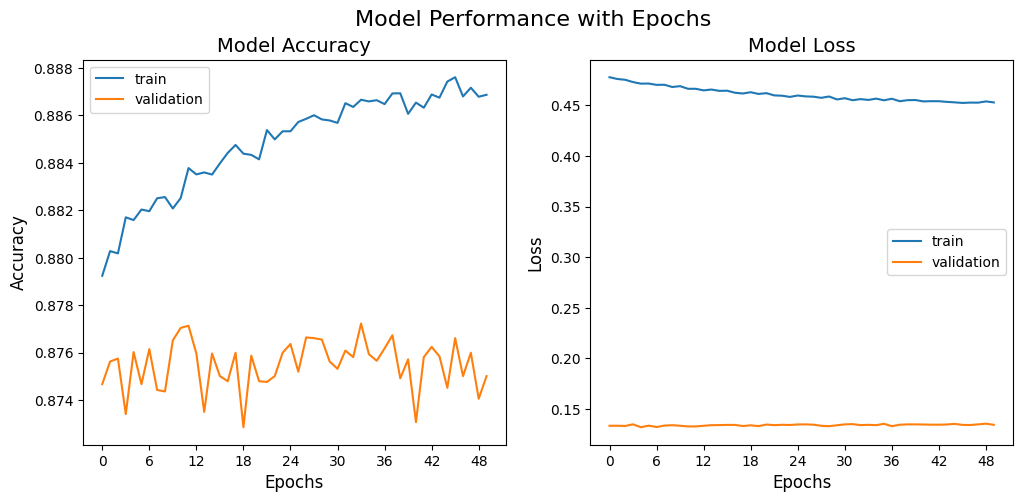

In [50]:
def accuracy_plot(history):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integers
    # Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to integers

accuracy_plot(bi_lstm_50)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Dropout

# Define the model architecture with Batch Normalization
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))

# Add a Bi-LSTM layer with Batch Normalization
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout for regularization

# Add another Bi-LSTM layer (optional)
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout for regularization

# Dense layers with Batch Normalization
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer for multiclass classification
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to confirm the architecture
model.summary()


NameError: name 'max_words' is not defined

In [6]:
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}
batch_history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels))

NameError: name 'train_data' is not defined

In [2]:
from tensorflow.keras.layers import SimpleRNN

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))
rnn_model.add(SimpleRNN(64))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(5, activation='softmax'))

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


NameError: name 'Sequential' is not defined

In [1]:
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}
rnn_history = rnn_model.fit(train_data, train_labels, batch_size=48, epochs= 50, class_weight = class_weight, validation_data=(test_data, test_labels))

NameError: name 'rnn_model' is not defined

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Add, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  # Add shortcut connection
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Define the input layer
inputs = Input(shape=(max_sequence_length,))

# Embedding layer
x = Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length)(inputs)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Adding residual blocks
for _ in range(3):
    x = residual_block(x, filters=64)

# Global Average Pooling and Dense layers
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Define the model
cnn_model = Model(inputs, outputs)

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to confirm the architecture
cnn_model.summary()



In [ ]:
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}
cnn_history = cnn_model.fit(train_data, train_labels, batch_size=48, epochs= 50, class_weight = class_weight, validation_data=(test_data, test_labels))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# Define the range of epochs for each model based on the number of epochs used
epochs = range(1, len(rnn_history.history['accuracy']) + 1)

plt.figure(figsize=(14, 10))

# Plot training and validation accuracy for all models
plt.subplot(2, 1, 1)
plt.plot(epochs, rnn_history.history['accuracy'], label='RNN Train Accuracy', linestyle='-', marker='o')
plt.plot(epochs, rnn_history.history['val_accuracy'], label='RNN Validation Accuracy', linestyle='--', marker='o')
plt.plot(epochs, cnn_history.history['accuracy'], label='CNN Train Accuracy', linestyle='-', marker='x')
plt.plot(epochs, cnn_history.history['val_accuracy'], label='CNN Validation Accuracy', linestyle='--', marker='x')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# Plot training and validation loss for all models
plt.subplot(2, 1, 2)
plt.plot(epochs, rnn_history.history['loss'], label='RNN Train Loss', linestyle='-', marker='o', alpha=0.7)
plt.plot(epochs, rnn_history.history['val_loss'], label='RNN Validation Loss', linestyle='--', marker='o', alpha=0.7)
plt.plot(epochs, cnn_history.history['loss'], label='CNN Train Loss', linestyle='-', marker='x', alpha=0.7)
plt.plot(epochs, cnn_history.history['val_loss'], label='CNN Validation Loss', linestyle='--', marker='x', alpha=0.7)
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis to display integers only

plt.tight_layout()
plt.show()
